# Wind Forecasting

## Prupose: predict the wind power within the next 48h
- based on hourly collected weather parameters

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, GRU, Conv1d, Dropout, MaxPool1d, BatchNorm1d
from torch.utils.data import TensorDataset, DataLoader

#set a random seed
import random
seed_value = 12321
torch.manual_seed(seed_value)
np.random.seed(seed_value)

#set CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


# Data Reading

### Data imported and processed form Kagle can be found at:
https://drive.google.com/drive/folders/1ZsC8JcLAQlhZGNaVrDMdVXLWh2X41ebF?usp=sharing 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "drive/My Drive/DL_project/GEF2012-wind-forecasting/"

In [5]:
train_csv = pd.read_csv(path + 'train.csv')
test_csv = pd.read_csv(path + 'test.csv')

In [6]:
# Your code to produce answers here:
from IPython.display import display, HTML
print("TRAINING SET")
display(train_csv[:5])
print('No of samples: ',train_csv.shape)
print('Attributes are:\n ',train_csv.columns)

print("\nTEST SET")
display(test_csv[:5])
print('No of samples: ',test_csv.shape)
print('Attributes are:\n ',test_csv.columns)

TRAINING SET


,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009070100,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009070101,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2,2009070102,0.020,0.175,0.178,0.033,0.015,0.026,0.000
3,2009070103,0.060,0.085,0.109,0.022,0.010,0.013,0.000
4,2009070104,0.045,0.032,0.079,0.039,0.010,0.000,0.000


No of samples:  (18757, 8)
Attributes are:
  Index(['date', 'wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7'], dtype='object')

TEST SET


,id,date
0,4866,2011122106
1,2167,2011060719
2,5522,2012020714
3,6474,2012041518
4,3889,2011101113


No of samples:  (7488, 2)
Attributes are:
  Index(['id', 'date'], dtype='object')


In [7]:
# convert the date into Timestamp object:
#training set
newdate_train = []
for i_date in range(len(train_csv.date)):
  datestr = str(train_csv['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_train.append(pd.to_datetime(date_form))

train_csv['Date'] = newdate_train
train_csv = train_csv.set_index('Date')


#test set
newdate_test = []
for i_date in range(len(test_csv.date)):
  datestr = str(test_csv['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_test.append(pd.to_datetime(date_form))

test_csv['Date'] = newdate_test
test_csv = test_csv.set_index('Date')

In [8]:
# Add columns: year, month, and weekday
train_csv['Year'] = train_csv.index.year
train_csv['Month'] = train_csv.index.month
train_csv['day'] = train_csv.index.day
train_csv['hour'] = train_csv.index.hour

test_csv['Year'] = test_csv.index.year
test_csv['Month'] = test_csv.index.month
test_csv['day'] = test_csv.index.day
test_csv['hour'] = test_csv.index.hour

### Monthly evaluation

In [9]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [10]:
# convert the date into Timestamp object:
#training set
newdate_train = []
for i_date in range(len(train.date)):
  datestr = str(train['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_train.append(pd.to_datetime(date_form))

train['Date'] = newdate_train
train = train.set_index('Date')


#test set
newdate_test = []
for i_date in range(len(test_csv.date)):
  datestr = str(test['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_test.append(pd.to_datetime(date_form))

test['Date'] = newdate_test
test = test.set_index('Date')

Text(0, 0.5, 'Wind Power')

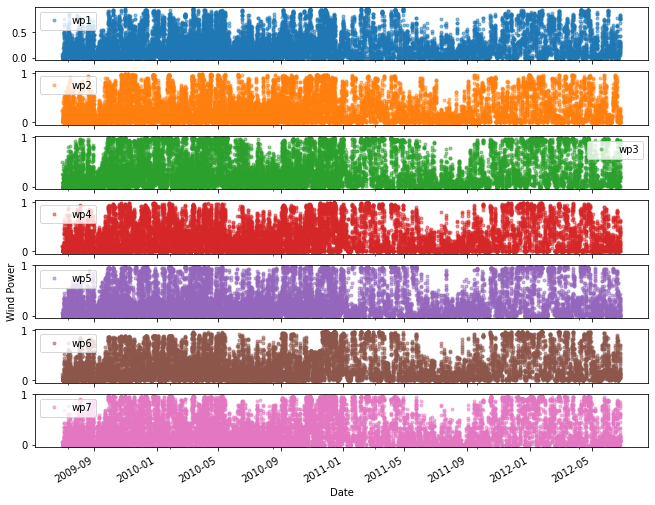

In [11]:
cols_plot = train.columns[1:8]
axes = train[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[4].set_ylabel('Wind Power')

In [12]:
# Specify the WP columns we want to include 
data_columns = train.columns[1:8]
# Resample to weekly frequency, aggregating with mean
train_weekly_mean = train[data_columns].resample('W').mean()
train_weekly_mean.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-05,0.136183,0.114283,0.099975,0.087567,0.109892,0.075983,0.055383
2009-07-12,0.195667,0.237923,0.152857,0.196298,0.103339,0.141560,0.121345
2009-07-19,0.219577,0.162464,0.212298,0.146702,0.183399,0.121494,0.107202


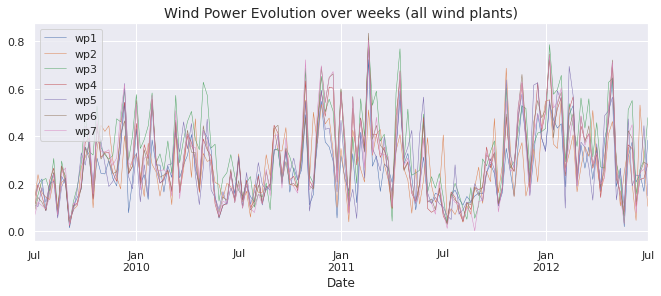

In [13]:
#plotting evolution over time for all WPs
#Evolution of WPs over all values in time
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
for wp in train.columns[1:8]:
  train_weekly_mean[wp].plot(linewidth=0.5);
  plt.legend(loc='upper left')
  plt.title('Wind Power Evolution over weeks (all wind plants)', fontsize = 14)

In [14]:
# Specify the WP columns we want to include 
data_columns = train.columns[1:8]
# Resample to monthly frequency, aggregating with mean
train_means_month = train[data_columns].resample('M').mean()
train_means_month.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-31,0.162945,0.154657,0.178030,0.137923,0.143727,0.111606,0.099379
2009-08-31,0.182888,0.185554,0.209464,0.207478,0.166766,0.206737,0.202368
2009-09-30,0.155025,0.161529,0.211086,0.160215,0.195524,0.157744,0.170704


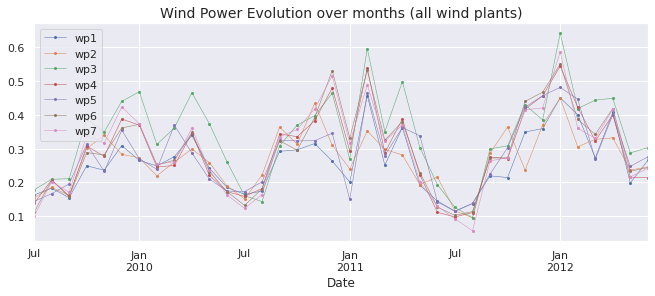

In [15]:
#plotting evolution over time for all WPs
for wp in train.columns[1:8]:
  train_means_month[wp].plot(linewidth=0.5,marker='o', markersize=2, linestyle='-')
  plt.legend(loc='upper left')
  plt.title('Wind Power Evolution over months (all wind plants)', fontsize = 14)

In [16]:
data_columns = train.columns[1:8]
train_monthly_sum = train[data_columns].resample('M').sum(min_count=28)
train_monthly_sum.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-31,121.231,115.065,132.454,102.615,106.933,83.035,73.938
2009-08-31,136.069,138.052,155.841,154.364,124.074,153.812,150.562
2009-09-30,111.618,116.301,151.982,115.355,140.777,113.576,122.907


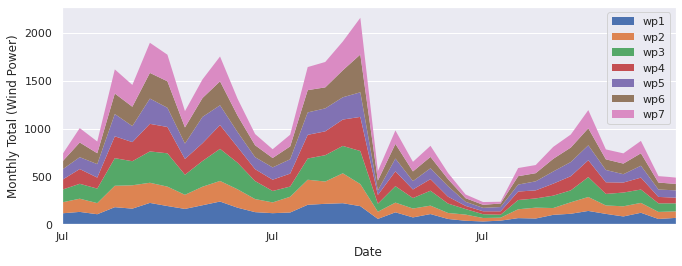

In [17]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
#ax.plot(train_monthly_sum['wp1'], color='black', label='wp1')
train_monthly_sum[data_columns].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (Wind Power)');

# WIND FARM 1 (WF1)

In [18]:
train_wp1_unprocessed = train_csv.drop(columns=['date','wp2','wp3','wp4','wp5','wp6','wp7'])

In [19]:
train_wp1_unprocessed['date'] = train_wp1_unprocessed.index.date
train_wp1_unprocessed = train_wp1_unprocessed.set_index('date')

## Add forecast attributes

Principle: make a table out of this


In [20]:

w1_forecast = pd.read_csv(path + 'windforecasts_wf1.csv')

# convert the date into Timestamp object:
#training set
newdate_forecast = []
for i_date in range(len(w1_forecast.date)):
  datestr = str(w1_forecast['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_forecast.append(pd.to_datetime(date_form))

w1_forecast['Date'] = newdate_forecast
w1_forecast = w1_forecast.set_index('Date')


In [152]:
w1_forecast['hour_forecast'] = w1_forecast.index.hour
w1_forecast['date'] = w1_forecast.index.date
w1_forecast['Number'] = [*range(len(w1_forecast))]
w1_forecast = w1_forecast.set_index('Number')
print(w1_forecast[:7])

              date  hors     u     v    ws      wd  hour_forecast
Number                                                           
0       2009-07-01     1  2.34 -0.79  2.47  108.68              0
1       2009-07-01     2  2.18 -0.99  2.40  114.31              0
2       2009-07-01     3  2.20 -1.21  2.51  118.71              0
3       2009-07-01     4  2.35 -1.40  2.73  120.86              0
4       2009-07-01     5  2.53 -1.47  2.93  120.13              0
5       2009-07-01     6  2.66 -1.29  2.96  115.79              0
6       2009-07-01     7  2.69 -0.81  2.81  106.71              0


In [154]:
# append u,v,ws and wd based on closest timeframe forecastings

import datetime

d = pd.DataFrame()
for i in range(len(train_wp1_unprocessed)):
  hour = int(train_wp1_unprocessed.iloc[i]['hour'])
  date = train_wp1_unprocessed.index[i]
  if hour == 0:
    date_forecast = date - datetime.timedelta(days=1)
    hour_forecast = 12
    hors = 13
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  elif (1 <= hour) and (hour <= 12):
    date_forecast = date
    hour_forecast = 0
    hors = hour
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  elif (13 <= hour) and (hour <= 23):
    date_forecast = date
    hour_forecast = 12
    hors = hour - 12
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  temp = pd.DataFrame(
      {
          'u': u,
          'v': v,
          'ws': ws,
          'wd': wd,
          'date_forecast' : date_forecast,
          'hour_forecast' : hour_forecast,
          'hors' : hors
      }
  )

  d = pd.concat([d, temp])

d.to_csv(path + 'wp1_extracted_forecast_vals')


#### Uploading the data

In [23]:
forecast_wp1_processed = pd.read_csv(path + 'wp1_extracted_forecast_vals')

In [24]:
# drop first row as we do not have a forecast for it
train_wp1_unprocessed = train_wp1_unprocessed.tail(train_wp1_unprocessed.shape[0] -1)

In [25]:
forecast_wp1_processed.reset_index(drop=True, inplace=True)
train_wp1_unprocessed.reset_index(drop=True, inplace=True)
train_wp1_unprocessed = pd.concat([forecast_wp1_processed, train_wp1_unprocessed], axis=1)

In [26]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    #for n in range(1, n_lags + 1):
    #    df_n[f"lag_p{n}"] = df_n["wp1"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_u{n}"] = df_n["u"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_v{n}"] = df_n["v"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_ws{n}"] = df_n["ws"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_wd{n}"] = df_n["wd"].shift(n)

    df_n = df_n.iloc[n_lags:]
    df_n['hourr'] = ["{0:0=2d}".format(df_n['hour'].iloc[i]) for i in range(len(df_n))]
    cols=["Year","Month","day","hourr"]
    df_n['proper_date'] = df_n[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

    print(df_n['proper_date'].iloc[0])

    return df_n

In [27]:
train_wp1_unprocessed

,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp1,Year,Month,day,hour
0,0,2.34,-0.79,2.47,108.68,2009-07-01,0,1,0.085,2009,7,1,1
1,1,2.18,-0.99,2.40,114.31,2009-07-01,0,2,0.020,2009,7,1,2
2,2,2.20,-1.21,2.51,118.71,2009-07-01,0,3,0.060,2009,7,1,3
3,3,2.35,-1.40,2.73,120.86,2009-07-01,0,4,0.045,2009,7,1,4
4,4,2.53,-1.47,2.93,120.13,2009-07-01,0,5,0.035,2009,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.77,-1.52,2.34,130.63,2012-06-26,0,8,0.170,2012,6,26,8
18752,104744,1.93,-1.52,2.46,128.25,2012-06-26,0,9,0.211,2012,6,26,9
18753,104745,2.10,-1.73,2.72,129.58,2012-06-26,0,10,0.251,2012,6,26,10
18754,104746,2.21,-2.19,3.11,134.64,2012-06-26,0,11,0.301,2012,6,26,11


In [28]:
# generte timelags for wp1
input_dim = 100

train_wp1 = generate_time_lags(train_wp1_unprocessed, input_dim)


2009-7-5-05


In [29]:
train_wp1['proper_date']

100       2009-7-5-05
101       2009-7-5-06
102       2009-7-5-07
103       2009-7-5-08
104       2009-7-5-09
             ...     
18751    2012-6-26-08
18752    2012-6-26-09
18753    2012-6-26-10
18754    2012-6-26-11
18755    2012-6-26-12
Name: proper_date, Length: 18656, dtype: object

In [30]:
def create_obs_per_row(idx, columns, df):
  #pow_lag = []

  u_lag = []
  v_lag = []
  ws_lag = []
  wd_lag = []
  date_l = []
  for col in columns:
    #if 'lag_p' in col:
    #  pow_lag.append(df[col].iloc[idx])
    if 'lag_u' in col:
      u_lag.append(df[col].iloc[idx])
    elif 'lag_v' in col:
      v_lag.append(df[col].iloc[idx])
    elif 'lag_ws' in col:
      ws_lag.append(df[col].iloc[idx])
    elif 'lag_wd' in col:
      wd_lag.append(df[col].iloc[idx])
    elif 'proper_date' in col:
      date = df[col].iloc[idx]
      date_l = [date] * 100
  #return pow_lag, u_lag, v_lag, ws_lag, wd_lag
  return u_lag, v_lag, ws_lag, wd_lag, date_l

In [31]:
X_list = []
Y_list = []
Date_list = []
 
for i in range(len(train_wp1)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wp1.columns, train_wp1)
  y_obs = train_wp1['wp1'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)

In [32]:
print(len(X_list))
print(len(Y_list))
print(len(Date_list))

18656
18656
18656


In [33]:
randomtestlist = random.sample(range(1, len(X_list)-100), 99)

## Splitting and Loading the Data

In [34]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, Date_list, ratio):
    X_test = []
    y_test = []
    date_test = []

    y_48h_last = y[-48:]
    X_48h_last = X[-48:]
    date_48h_last = Date_list[-48:]
    #print(len(date_48h_last))

    y = y[:-48]
    X = X[:-48]
    Date_list = Date_list[:-48]

    idx_to_delete = []
    for rand_idx in randomtestlist:
      y_48h = y[rand_idx:rand_idx+48]
      X_48h = X[rand_idx:rand_idx+48]
      date_48h = Date_list[rand_idx:rand_idx+48]
      #print(len(Date_list))
      #print(len(date_48h))

      X_test.extend(X_48h)
      y_test.extend(y_48h)
      date_test.extend(date_48h)

      del X[rand_idx:rand_idx+48]
      del y[rand_idx:rand_idx+48]
      del Date_list[rand_idx:rand_idx+48]

    X_test.extend(X_48h_last)
    y_test.extend(y_48h_last)
    date_test.extend(date_48h_last)
    val_ratio = 0.3

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test, date_test

In [35]:
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)

In [36]:
# data scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    

In [37]:
scaler = get_scaler('minmax')

# scaling the data
for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print(y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))


(10035, 1)


In [38]:
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

In [39]:
# loading the data

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [40]:
len(train_features)

10035

# Modelling - 48h Prediction

# CNN

In [41]:
import torch
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [42]:
dropout_prob = 0.2


# <-- Input shape
height, width, channels = (X_train[0].shape[0], X_train[0].shape[1], 1)

# <-- No. Filters
num_filters_conv1 =  8 # <-- Filters in your convolutional layer
num_filters_conv2 = 8

# <-- Kernel size
kernel_size_conv1 = 4
kernel_size_conv2 = 4
kernel_size_pooling = 2

# <-- Padding
padding_conv1 = 2 
padding_conv2 = 2 
padding_pooling = 0

# <-- Stride
conv_stride_1 =  2      
conv_stride_2 = 2
pooling_stride = 2

# <-- Fully Connected Layer
n_hidden = 100

# Convolution helper functions 
def compute_conv_dim(dim_size, kernel_size, padding_conv, stride_conv):
    return int((dim_size - kernel_size + 2 * padding_conv) / stride_conv + 1)

def compute_pool_dim(dim_size, kernel_size, stride_conv):
    return int((dim_size - kernel_size ) / stride_conv + 1)

## Net class:    

class ConvNet(nn.Module):
    def __init__(self, n_hidden, output_dim, dropout_prob):
        super(ConvNet, self).__init__()

        # Conv. Layer 1        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=conv_stride_1,
                             padding=padding_conv1)
        
        self.height_conv1 = compute_conv_dim(height, kernel_size_conv1, padding_conv1, conv_stride_1)
        self.width_conv1 = compute_conv_dim(width, kernel_size_conv1, padding_conv1, conv_stride_1)

        # Addign an extra layer: does not improve much...
        #self.input_c1 = kernel_size_conv1*self.width_conv2*self.height_conv1
        '''
        # Conv. Layer 2
        self.conv_2 = nn.Conv2d(in_channels=num_filters_conv1,
                        out_channels=num_filters_conv2,
                        kernel_size=kernel_size_conv2,
                        stride=conv_stride_2,
                        padding=padding_conv2)
        
        self.height_conv2 = compute_conv_dim(self.height_conv1, kernel_size_conv2, padding_conv2, conv_stride_2)
        self.width_conv2 = compute_conv_dim(self.width_conv1, kernel_size_conv2, padding_conv2, conv_stride_2)
        '''
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=kernel_size_pooling, 
                          stride=pooling_stride)
        

        self.height_pool = compute_conv_dim(self.height_conv1, kernel_size_pooling, padding_pooling, pooling_stride)
        self.width_pool = compute_conv_dim(self.width_conv1, kernel_size_pooling, padding_pooling, pooling_stride)

        self.num_l1 = num_filters_conv2*self.height_pool * self.width_pool

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Hidden Layer

        self.hidden= Linear(in_features=self.num_l1,
                            out_features=n_hidden)
        #output:
        self.predict = Linear(in_features=n_hidden, 
                            out_features=output_dim)
         
        
    def forward(self, x):
       # input should be: [B,C,W,H]

        x = relu(self.conv_1(x))
        x = self.dropout(x)
        #print('Output, 1st layer of conv: ',x.shape)
        
        #x = relu(self.conv_2(x))
        #x = self.dropout(x)

        #print('Output, 2nd layer of conv: ',x.shape)
        x = self.pool(x)
        #print(x.shape)

        x = torch.flatten(x, 1)         # flatten all dimensions except batch    
        #print(x.shape)
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # output prediction
        return x


In [43]:
# TESTING
#Test the forward pass with dummy data
x = np.random.normal(0,1, (5, 1, 4, 100)).astype('float32') #B,C,W,H

net = ConvNet(n_hidden = 50, output_dim = 48, dropout_prob= 0.2)

out = net(Variable(torch.from_numpy(x)))

print(out.shape)

torch.Size([5, 48])


# TRAINING
## Training using MAE as loss function 

In [44]:
#@title Default title text
n_epochs = 50
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    # training step
    def train_step_cnn(self, x, y):
        y = y.to(device)
        # Sets model to train mode
        self.model.train()

        torch_x = torch.from_numpy(x).to(device)
        # Makes predictions
        yhat = self.model(Variable(torch_x))

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train_step_rnn(self, x, y):
        y = y.to(device)
        # Sets model to train mode
        self.model.train()

        x = x.to(device)
        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    #training
    def train(self, train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=1):
        #model_path = f'models/{self.model}_{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []

            # train set
            for x_batch, y_batch in train_loader:
                #reshape input according to the model used
                if self.model.__class__.__name__ == 'ConvNet':
                  x_batch = x_batch.view([batch_size, -1, n_features])

                  #print('x_batch shape: ',x_batch.shape)

                  x_batch = np.expand_dims(x_batch, axis=1)
                  y_batch = y_batch

                  loss = self.train_step_cnn(x_batch, y_batch)

                elif self.model.__class__.__name__ == 'LSTMNet':
                  x_batch = x_batch.view([batch_size, -1, n_features])
                  y_batch = y_batch

                  loss = self.train_step_rnn(x_batch, y_batch)

                loss = loss
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            # validation set
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    
                    #reshape input according to the model used
                    if self.model.__class__.__name__ == 'ConvNet':
                      x_val = x_val.view([batch_size, -1, n_features])
                      x_val = np.expand_dims(x_val, axis=1)
                      
                      self.model.eval()
                      x_val = torch.from_numpy(x_val).to(device)
                      yhat = self.model(Variable(x_val))
                      
                    elif self.model.__class__.__name__ == 'LSTMNet':
                      x_val = x_val.view([batch_size, -1, n_features])
                      self.model.eval()

                      x_val = x_val.to(device)
                      yhat = self.model(x_val)
                    y_val = y_val.to(device)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)

                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        #torch.save(self.model.state_dict(), model_path)

    #evaluation of the test set
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                #reshape input according to the model used
                if self.model.__class__.__name__ == 'ConvNet':
                  x_test = x_test.view([batch_size, -1, n_features])
                  x_test = np.expand_dims(x_test, axis=1)
                  y_test = y_test.to(device)
                  self.model.eval()
                  x_test = torch.from_numpy(x_test).to(device)
                  yhat = self.model(Variable(x_test))

                elif self.model.__class__.__name__ == 'LSTMNet':
                  x_test = x_test.view([batch_size, -1, n_features])

                  x_test = x_test.to(device)
                  y_test = y_test.to(device)
                  self.model.eval()
                  #yhat = self.model(Variable(torch.from_numpy(x_test_wp)), Variable(torch.from_numpy(x_test_ws)), Variable(torch.from_numpy(x_test_wd)), Variable(torch.from_numpy(x_test_u)), Variable(torch.from_numpy(x_test_v)))
                  yhat = self.model(x_test)

                predictions.append(yhat.cpu().data.numpy())
                values.append(y_test.cpu().data.numpy())

        return predictions, values


    def plot_losses(self):
        train_losses = self.train_losses
        val_losses = self.val_losses

        plt.plot(train_losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")


        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

    

[1/50] Training loss: 12.6934	 Validation loss: 1.4750
[2/50] Training loss: 1.9568	 Validation loss: 0.7638
[3/50] Training loss: 1.0013	 Validation loss: 0.4757
[4/50] Training loss: 0.6302	 Validation loss: 0.3175
[5/50] Training loss: 0.4413	 Validation loss: 0.2936
[6/50] Training loss: 0.3209	 Validation loss: 0.2451
[7/50] Training loss: 0.2564	 Validation loss: 0.2307
[8/50] Training loss: 0.2280	 Validation loss: 0.2095
[9/50] Training loss: 0.1914	 Validation loss: 0.1396
[10/50] Training loss: 0.1377	 Validation loss: 0.1233
[20/50] Training loss: 0.0633	 Validation loss: 0.0755
[30/50] Training loss: 0.0438	 Validation loss: 0.0603
[40/50] Training loss: 0.0381	 Validation loss: 0.0543
[50/50] Training loss: 0.0343	 Validation loss: 0.0470


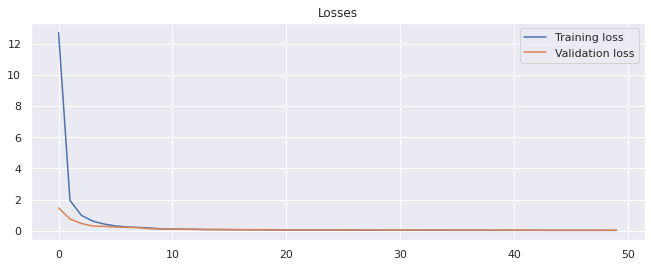

In [45]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
learning_rate = 1e-3
weight_decay = 1e-6
batch_size = 64
n_epochs = 50


model = ConvNet(n_hidden = 50, output_dim = 1, dropout_prob= 0.2)
model = model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_cnn = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)


opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# RNN - LSTM
- this time we have 5 series: power, ws, wd, u, v
- run each through an LSTM
- concatenate and run through a hidden layer (?)
- output

In [46]:
no_features, input_dim = (X_train[0].shape[0], X_train[0].shape[1])

print(input_dim, no_features)

100 4


In [47]:

#height, width, channels = IMAGE_SHAPE


# Keep track of features to output layer

hidden_size_lstm = 120
# <-- Input shape
no_features, input_dim = (X_train[0].shape[0], X_train[0].shape[1])

# [batch_size, sequence_length, input_dim]
# x_batch = x_batch.view([batch_size, -1, n_features])
# X[B, n_lag, forecast_features (4)]

    
class LSTMNet(nn.Module):
    def __init__(self, n_hidden, output_dim, n_hidden_fully_conntected, dropout_prob):
        super(LSTMNet, self).__init__()

        # Batch normalization - didn't use as it does not improve the kaggle score
        # self.fc1_bn=nn.BatchNorm2d(num_filters_conv2)

        # LSTM:

        self.lstm = nn.LSTM(input_size = int(input_dim), hidden_size = n_hidden, num_layers = 1, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Fully Connected Layer:
        self.hidden= Linear(in_features=n_hidden*no_features,
                    out_features=n_hidden_fully_conntected)
        # Output
        self.l_out = Linear(in_features= n_hidden_fully_conntected,
                            out_features=output_dim,
                            bias=False)
        
    def forward(self, x):
        #print('x before rnn ',x.shape)
        x, (_, _) = self.lstm(x)

        x = x.reshape(-1, self.lstm.hidden_size*no_features)

        #print(x.shape)
        x = F.relu(self.hidden(x))
        x = self.dropout(x)   
        out = self.l_out(x) 
        #print('output: ',out.shape)
        return out

net = LSTMNet(n_hidden = 100, output_dim =  48, n_hidden_fully_conntected= 500, dropout_prob = 0.2)

print(net)

LSTMNet(
  (lstm): LSTM(100, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden): Linear(in_features=400, out_features=500, bias=True)
  (l_out): Linear(in_features=500, out_features=48, bias=False)
)


In [48]:
# TESTING

# Size: [batch_size, no_features, input_dim]
x = torch.randn(64, 4, 100)

#lstm = nn.LSTM(input_size=int(input_dim), hidden_size=100, batch_first=True)

#output, _ = lstm(x)
#output.size()  

net = LSTMNet(n_hidden = 100, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)

out = net(x)
print(out.shape)

torch.Size([64, 1])


[1/50] Training loss: 0.0816	 Validation loss: 0.0843
[2/50] Training loss: 0.0613	 Validation loss: 0.0764
[3/50] Training loss: 0.0575	 Validation loss: 0.0739
[4/50] Training loss: 0.0550	 Validation loss: 0.0719
[5/50] Training loss: 0.0528	 Validation loss: 0.0701
[6/50] Training loss: 0.0504	 Validation loss: 0.0685
[7/50] Training loss: 0.0487	 Validation loss: 0.0669
[8/50] Training loss: 0.0468	 Validation loss: 0.0655
[9/50] Training loss: 0.0458	 Validation loss: 0.0641
[10/50] Training loss: 0.0442	 Validation loss: 0.0630
[20/50] Training loss: 0.0345	 Validation loss: 0.0556
[30/50] Training loss: 0.0289	 Validation loss: 0.0523
[40/50] Training loss: 0.0255	 Validation loss: 0.0507
[50/50] Training loss: 0.0226	 Validation loss: 0.0501


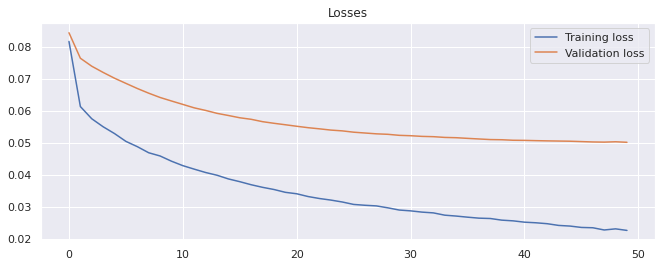

In [49]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
learning_rate = 1e-5
weight_decay = 1e-10
batch_size = 64
n_epochs = 50


model = LSTMNet(n_hidden = 120, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)
model = model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_rnn = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()



# Evaluation

## LSTM with MSE loss

In [50]:
predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [51]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, y_test, scaler):
    df_result = pd.DataFrame(data={"value": values, "prediction": predictions})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    date_test_proper = [date_test[i][0] for i in range(len(date_test))]
    df_result['Date-str'] = date_test_proper
    df_result['Date'] = pd.to_datetime(df_result['Date-str'])
    return df_result

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn = format_predictions(preds , vals, y_test, scaler)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction, squared= False),
            'mse' : mean_squared_error(df.value, df.prediction)
            }

result_metrics = calculate_metrics(df_result_rnn)
print('Result metrics - LSTM with MSE (WF1): ', result_metrics)

Result metrics - LSTM with MSE (WF1):  {'mae': 0.14496972, 'rmse': 0.18706116, 'mse': 0.03499188}


## Baseline Model

In [53]:
from sklearn.linear_model import LinearRegression

model_baseline = LinearRegression()

In [54]:
def train_baseline_model(test_ratio, model, X_list, Y_list, date_test):
    X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
    X_train = np.array(X_train, dtype=np.float64)
    X_val = np.array(X_val, dtype=np.float64)
    X_test = np.array(X_test, dtype=np.float64 )
    y_train = np.array(y_train, dtype=np.float64)
    y_val = np.array(y_val, dtype=np.float64)
    y_test = np.array(y_test, dtype=np.float64)

    nsample , nx, ny = X_train.shape
    d2_X_train = X_train.reshape((nsample, nx*ny))
    #print(d2_X_train.shape)

    
    model.fit(d2_X_train, y_train)
    
    nsample , nx, ny = X_test.shape
    d2_X_test = X_test.reshape((nsample, nx*ny))
    prediction = model.predict(d2_X_test)

    result = pd.DataFrame(y_test)

    result["prediction"] = prediction
    result = result.sort_index()

    date_test_proper = []
    date_test_proper = [date_test[i][0] for i in range(len(date_test))]

    result['Date-str'] = date_test_proper

    result['Date'] = pd.to_datetime(result['Date-str'])
    

    return result

In [55]:
def calculate_metrics_baseline(df):
    return {'mae' : mean_absolute_error(df[0], df.prediction),
            'rmse' : mean_squared_error(df[0], df.prediction) ** 0.5,
             'mse' : mean_squared_error(df[0], df.prediction)}

In [56]:
training_session = 'WF1'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1 {'mae': 0.12439846928229054, 'rmse': 0.1633114145949657, 'mse': 0.026670618137008776}


In [57]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_predictions(df_result, df_baseline,title_str):
    data = []
    
    df_result.set_index(['Date'],inplace=True)
    df_baseline.set_index(['Date'],inplace=True)
    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='linear regression',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    
    layout = dict(
        title=title_str + " - Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Wind Power", ticklen=5, zeroline=False),
    )
    #xaxis = df_result['Date']

    fig = dict(data=data, layout=layout)
    iplot(fig)
    
%matplotlib inline    
# Set notebook mode to work in offline
#pyo.init_notebook_mode()

plot_predictions(df_result_rnn[-96:-48], df_baseline[-96:-48], 'LSTM with MSE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1) - 48h window')

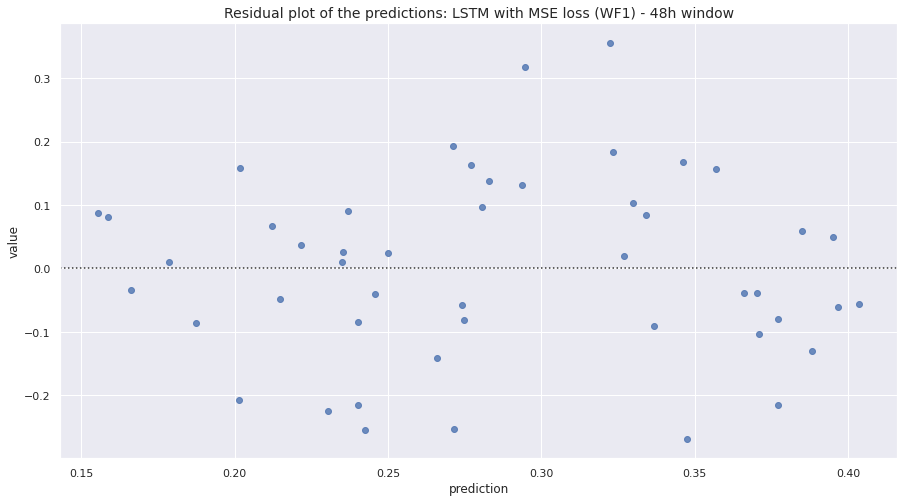

In [58]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn[-96:-48]['prediction'], y=df_result_rnn[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1) - 48h window', size=14)


## CNN with MSE loss

In [59]:
# with CNN: 
predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [60]:
preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn)
print('Result metrics for CNN with MSE loss (WF1): ', result_metrics)

Result metrics for CNN with MSE loss (WF1):  {'mae': 0.15133704, 'rmse': 0.19075543, 'mse': 0.036387634}


In [61]:
plot_predictions(df_result_cnn[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1) - 48h window')

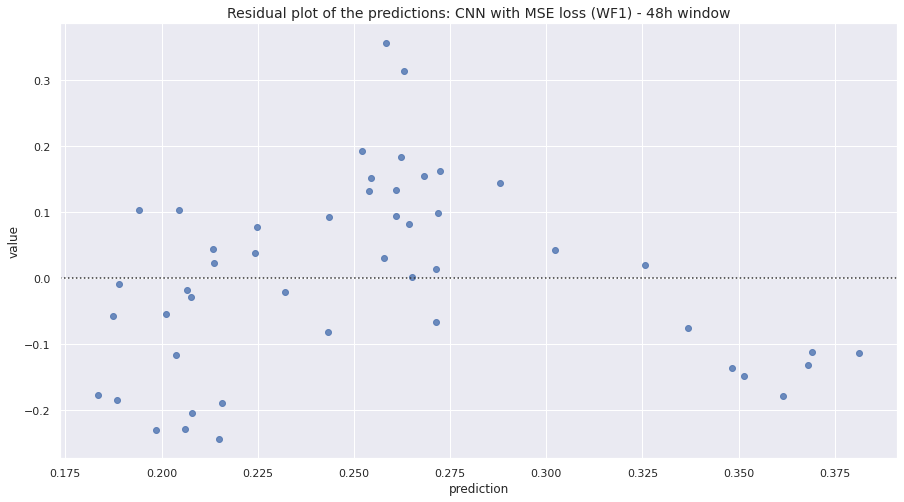

In [62]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn[-96:-48]['prediction'], y=df_result_cnn[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1) - 48h window', size=14)

# Training using MAE as loss function 

---



# CNN with MAE loss

[1/50] Training loss: 0.8642	 Validation loss: 0.3214
[2/50] Training loss: 0.2637	 Validation loss: 0.2443
[3/50] Training loss: 0.2107	 Validation loss: 0.2251
[4/50] Training loss: 0.1935	 Validation loss: 0.2167
[5/50] Training loss: 0.1809	 Validation loss: 0.2131
[6/50] Training loss: 0.1699	 Validation loss: 0.2012
[7/50] Training loss: 0.1649	 Validation loss: 0.1920
[8/50] Training loss: 0.1597	 Validation loss: 0.1955
[9/50] Training loss: 0.1557	 Validation loss: 0.1871
[10/50] Training loss: 0.1517	 Validation loss: 0.1874
[20/50] Training loss: 0.1367	 Validation loss: 0.1787
[30/50] Training loss: 0.1198	 Validation loss: 0.1781
[40/50] Training loss: 0.1103	 Validation loss: 0.1764
[50/50] Training loss: 0.1017	 Validation loss: 0.1796


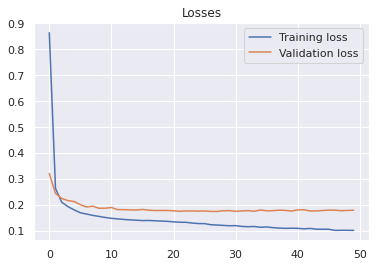

In [63]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
batch_size = 64
n_epochs = 50


model = ConvNet(n_hidden = 50, output_dim = 1, dropout_prob= 0.2)
model = model.to(device)


loss_fn = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_cnn_mae = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_cnn_mae.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn_mae.plot_losses()

predictions, values = opt_cnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Evaluation

In [64]:
# with CNN: 
predictions, values = opt_cnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_mae = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_mae)
print('Result metrics for CNN with MAE loss (WF1): ', result_metrics)

Result metrics for CNN with MAE loss (WF1):  {'mae': 0.15303613, 'rmse': 0.21288551, 'mse': 0.045320243}


In [65]:
plot_predictions(df_result_cnn_mae[-96:-48], df_baseline[-96:-48], 'CNN with MAE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MAE loss (WF1) - 48h window')

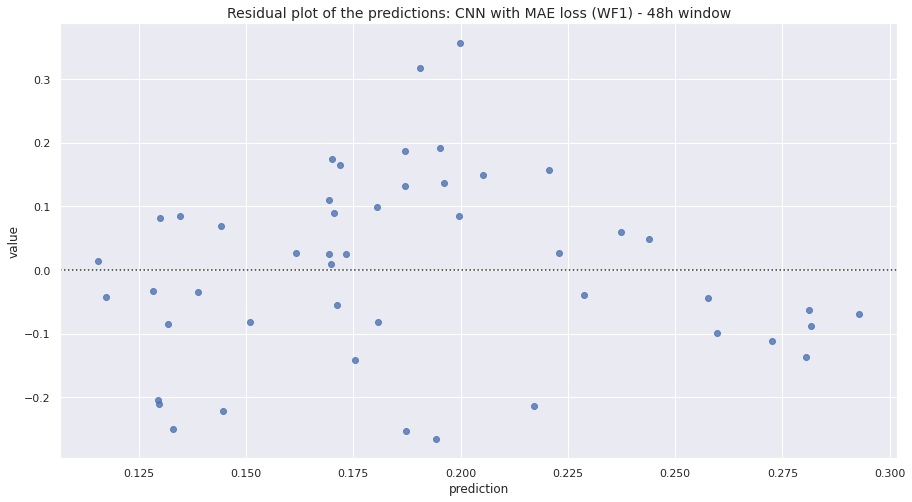

In [66]:
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_mae[-96:-48]['prediction'], y=df_result_cnn_mae[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MAE loss (WF1) - 48h window', size=14)

# LSTM with MAE loss

[1/50] Training loss: 0.2036	 Validation loss: 0.2220
[2/50] Training loss: 0.1868	 Validation loss: 0.2164
[3/50] Training loss: 0.1806	 Validation loss: 0.2131
[4/50] Training loss: 0.1759	 Validation loss: 0.2099
[5/50] Training loss: 0.1713	 Validation loss: 0.2072
[6/50] Training loss: 0.1682	 Validation loss: 0.2051
[7/50] Training loss: 0.1652	 Validation loss: 0.2029
[8/50] Training loss: 0.1619	 Validation loss: 0.2007
[9/50] Training loss: 0.1590	 Validation loss: 0.1987
[10/50] Training loss: 0.1570	 Validation loss: 0.1972
[20/50] Training loss: 0.1393	 Validation loss: 0.1857
[30/50] Training loss: 0.1278	 Validation loss: 0.1803
[40/50] Training loss: 0.1204	 Validation loss: 0.1768
[50/50] Training loss: 0.1134	 Validation loss: 0.1749


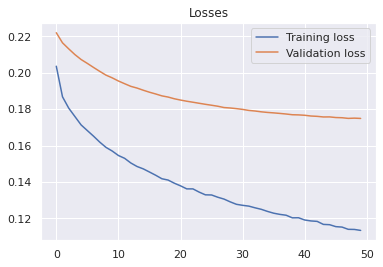

In [67]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-5
weight_decay = 1e-10
batch_size = 64
n_epochs = 50


model = LSTMNet(n_hidden = 120, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)
model = model.to(device)

loss_fn = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_rnn_mae = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_rnn_mae.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn_mae.plot_losses()

In [68]:
# with RNN: 
predictions, values = opt_rnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_mae = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_mae)
print('Result metrics for LSTM with MAE loss (WF1): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1):  {'mae': 0.14514166, 'rmse': 0.19257765, 'mse': 0.03708615}


In [69]:
plot_predictions(df_result_rnn_mae[-96:-48], df_baseline[-96:-48],'LSTM with MAE loss')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MAE loss - 48h window')

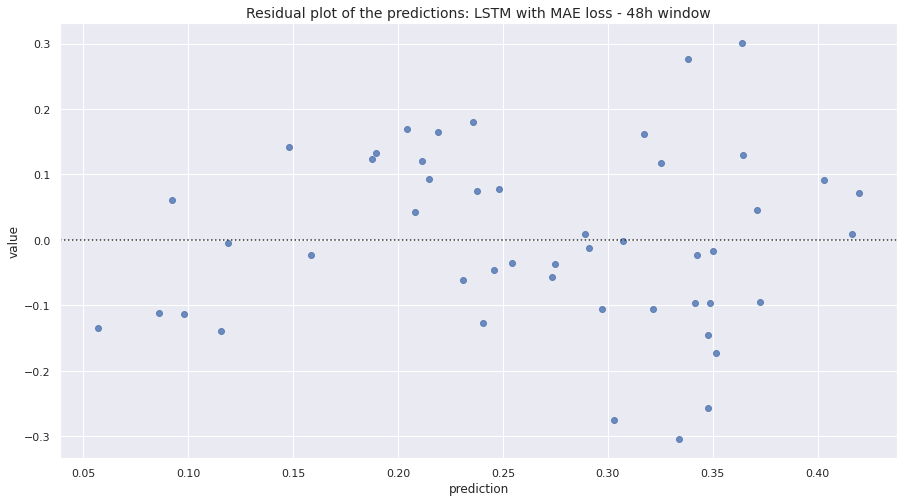

In [70]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_mae[-96:-48]['prediction'], y=df_result_rnn_mae[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MAE loss - 48h window', size=14)

# Model Training over several Wind Farms (WFs)

The models created above will be now trained on the data from the other 6 windfarms. Although the measurements from each wind farm are independent, we would like to test whether the model can improve and discover new patterns when fed with new data. 

### Generating the data-sets from the other windfarms: WP2, ..., WP7

The data will be generated as above and the model will be subsequentially trained on the datasets. 

In [71]:
# function to process the data for each wind farm
def process_windfarm_data(w_forecast, train_wp_unprocessed):

  import datetime

  # convert the date into Timestamp object:
  #training set
  newdate_forecast = []
  for i_date in range(len(w_forecast.date)):
    datestr = str(w_forecast['date'][i_date])
    date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
    newdate_forecast.append(pd.to_datetime(date_form))

  w_forecast['Date'] = newdate_forecast
  w_forecast = w_forecast.set_index('Date')

  #indexing
  w_forecast['hour_forecast'] = w_forecast.index.hour
  w_forecast['date'] = w_forecast.index.date
  w_forecast['Number'] = [*range(len(w_forecast))]
  w_forecast = w_forecast.set_index('Number')

  # append u,v,ws and wd based on closest timeframe forecastings
  

  d = pd.DataFrame()
  for i in range(len(train_wp_unprocessed)):
    hour = int(train_wp_unprocessed.iloc[i]['hour'])
    date = train_wp_unprocessed.index[i]
    if hour == 0:
      date_forecast = date - datetime.timedelta(days=1)
      hour_forecast = 12
      hors = 13
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    elif (1 <= hour) and (hour <= 12):
      date_forecast = date
      hour_forecast = 0
      hors = hour
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    elif (13 <= hour) and (hour <= 23):
      date_forecast = date
      hour_forecast = 12
      hors = hour - 12
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    temp = pd.DataFrame(
        {
            'u': u,
            'v': v,
            'ws': ws,
            'wd': wd,
            'date_forecast' : date_forecast,
            'hour_forecast' : hour_forecast,
            'hors' : hors
        }
    )

    d = pd.concat([d, temp])

  return d

## Preparing the data for the other wind farms 
(commented as it only needs to be done once)


In [79]:

train_wp2_unprocessed = train_csv.drop(columns=['date','wp1','wp3','wp4','wp5','wp6','wp7'])
train_wp2_unprocessed['date'] = train_wp2_unprocessed.index.date
train_wp2_unprocessed = train_wp2_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf2_forecast = pd.read_csv(path + 'windforecasts_wf2.csv')

d = process_windfarm_data(wf2_forecast, train_wp2_unprocessed)

d.to_csv(path + 'wf2_extracted_forecast_vals')


In [80]:
train_wp3_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp4','wp5','wp6','wp7'])
train_wp3_unprocessed['date'] = train_wp3_unprocessed.index.date
train_wp3_unprocessed = train_wp3_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf3_forecast = pd.read_csv(path + 'windforecasts_wf3.csv')

d = process_windfarm_data(wf3_forecast, train_wp3_unprocessed)

d.to_csv(path + 'wf3_extracted_forecast_vals')


In [81]:

train_wp4_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp5','wp6','wp7'])
train_wp4_unprocessed['date'] = train_wp4_unprocessed.index.date
train_wp4_unprocessed = train_wp4_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf4_forecast = pd.read_csv(path + 'windforecasts_wf4.csv')

d = process_windfarm_data(wf4_forecast, train_wp4_unprocessed)

d.to_csv(path + 'wf4_extracted_forecast_vals')


In [82]:

train_wp5_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp6','wp7'])
train_wp5_unprocessed['date'] = train_wp5_unprocessed.index.date
train_wp5_unprocessed = train_wp5_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf5_forecast = pd.read_csv(path + 'windforecasts_wf5.csv')

d = process_windfarm_data(wf5_forecast, train_wp5_unprocessed)

d.to_csv(path + 'wf5_extracted_forecast_vals')


In [83]:

train_wp6_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp5','wp7'])
train_wp6_unprocessed['date'] = train_wp6_unprocessed.index.date
train_wp6_unprocessed = train_wp6_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf6_forecast = pd.read_csv(path + 'windforecasts_wf6.csv')

d = process_windfarm_data(wf6_forecast, train_wp6_unprocessed)

d.to_csv(path + 'wf6_extracted_forecast_vals')


In [84]:

train_wp7_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp5','wp6'])
train_wp7_unprocessed['date'] = train_wp7_unprocessed.index.date
train_wp7_unprocessed = train_wp7_unprocessed.set_index('date')


# Do only once and export - add forecast attributes
wf7_forecast = pd.read_csv(path + 'windforecasts_wf7.csv')

d = process_windfarm_data(wf7_forecast, train_wp7_unprocessed)

d.to_csv(path + 'wf7_extracted_forecast_vals')


# Further training of the best model (CNN with MSE loss)
- training it with more data from the other wind farms

# + WF2

In [85]:
forecast_wf2_processed = pd.read_csv(path + 'wf2_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp2_unprocessed = train_wp2_unprocessed.tail(train_wp2_unprocessed.shape[0] -1)

forecast_wf2_processed.reset_index(drop=True, inplace=True)
train_wp2_unprocessed.reset_index(drop=True, inplace=True)
train_wf2_processed = pd.concat([forecast_wf2_processed, train_wp2_unprocessed], axis=1)

# generte timelags for WF2
input_dim = 100

train_wf2 = generate_time_lags(train_wf2_processed, input_dim)

train_wf2

2009-7-5-05


,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp2,Year,Month,day,hour,lag_u1,lag_u2,lag_u3,lag_u4,lag_u5,lag_u6,lag_u7,lag_u8,lag_u9,lag_u10,lag_u11,lag_u12,lag_u13,lag_u14,lag_u15,lag_u16,lag_u17,lag_u18,lag_u19,lag_u20,lag_u21,lag_u22,lag_u23,lag_u24,lag_u25,lag_u26,lag_u27,...,lag_wd63,lag_wd64,lag_wd65,lag_wd66,lag_wd67,lag_wd68,lag_wd69,lag_wd70,lag_wd71,lag_wd72,lag_wd73,lag_wd74,lag_wd75,lag_wd76,lag_wd77,lag_wd78,lag_wd79,lag_wd80,lag_wd81,lag_wd82,lag_wd83,lag_wd84,lag_wd85,lag_wd86,lag_wd87,lag_wd88,lag_wd89,lag_wd90,lag_wd91,lag_wd92,lag_wd93,lag_wd94,lag_wd95,lag_wd96,lag_wd97,lag_wd98,lag_wd99,lag_wd100,hourr,proper_date
100,388,0.83,-0.43,0.93,117.60,2009-07-05,0,5,0.021,2009,7,5,5,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,1.83,2.23,...,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,121.76,120.20,05,2009-7-5-05
101,389,0.42,0.04,0.42,84.74,2009-07-05,0,6,0.032,2009,7,5,6,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,1.83,...,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,121.76,06,2009-7-5-06
102,390,0.66,1.10,1.28,30.95,2009-07-05,0,7,0.037,2009,7,5,7,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,...,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,07,2009-7-5-07
103,391,1.32,2.30,2.65,29.98,2009-07-05,0,8,0.058,2009,7,5,8,0.66,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,...,129.51,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,08,2009-7-5-08
104,392,2.11,3.04,3.70,34.69,2009-07-05,0,9,0.122,2009,7,5,9,1.32,0.66,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,...,128.36,129.51,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,09,2009-7-5-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.99,-1.37,2.42,124.49,2012-06-26,0,8,0.138,2012,6,26,8,2.09,2.14,2.10,2.07,2.11,2.32,2.77,3.20,4.11,4.36,4.62,4.97,5.26,5.30,4.94,4.28,3.44,2.56,1.71,1.01,0.36,-0.21,-0.72,-1.13,-1.37,-1.30,-0.85,...,132.73,126.96,121.92,120.57,125.93,20.25,20.05,30.76,42.87,46.25,43.15,35.01,19.40,357.84,337.88,325.60,323.43,340.85,324.77,330.08,337.42,342.13,343.39,341.56,336.79,330.01,322.66,316.57,313.40,318.39,317.71,320.59,326.93,335.19,344.35,354.51,5.85,15.96,08,2012-6-26-08
18752,104744,1.87,-1.40,2.34,126.69,2012-06-26,0,9,0.106,2012,6,26,9,1.99,2.09,2.14,2.10,2.07,2.11,2.32,2.77,3.20,4.11,4.36,4.62,4.97,5.26

In [86]:
train_wf2_processed

,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp2,Year,Month,day,hour
0,0,3.32,-1.93,3.84,120.20,2009-07-01,0,1,0.249,2009,7,1,1
1,1,2.88,-1.78,3.39,121.76,2009-07-01,0,2,0.175,2009,7,1,2
2,2,2.46,-1.71,2.99,124.85,2009-07-01,0,3,0.085,2009,7,1,3
3,3,2.07,-1.68,2.67,129.09,2009-07-01,0,4,0.032,2009,7,1,4
4,4,1.77,-1.65,2.42,132.96,2009-07-01,0,5,0.011,2009,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.99,-1.37,2.42,124.49,2012-06-26,0,8,0.138,2012,6,26,8
18752,104744,1.87,-1.40,2.34,126.69,2012-06-26,0,9,0.106,2012,6,26,9
18753,104745,1.78,-1.40,2.26,128.19,2012-06-26,0,10,0.090,2012,6,26,10
18754,104746,1.76,-1.40,2.25,128.54,2012-06-26,0,11,0.058,2012,6,26,11


### Preparing the inpout data (X and Y)

In [87]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf2)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf2.columns, train_wf2)
  y_obs = train_wf2['wp2'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))


Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [88]:
# train baseline model
training_session = 'WF1+WF2'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2 {'mae': 0.13675377200135197, 'rmse': 0.1773532451807202, 'mse': 0.03145417357613266}


### CNN with MSE

[1/50] Training loss: 0.0495	 Validation loss: 0.0709
[2/50] Training loss: 0.0473	 Validation loss: 0.0552
[3/50] Training loss: 0.0456	 Validation loss: 0.0499
[4/50] Training loss: 0.0466	 Validation loss: 0.0469
[5/50] Training loss: 0.0444	 Validation loss: 0.0454
[6/50] Training loss: 0.0428	 Validation loss: 0.0458
[7/50] Training loss: 0.0415	 Validation loss: 0.0456
[8/50] Training loss: 0.0419	 Validation loss: 0.0453
[9/50] Training loss: 0.0402	 Validation loss: 0.0452
[10/50] Training loss: 0.0396	 Validation loss: 0.0451
[20/50] Training loss: 0.0297	 Validation loss: 0.0472
[30/50] Training loss: 0.0238	 Validation loss: 0.0481
[40/50] Training loss: 0.0209	 Validation loss: 0.0490
[50/50] Training loss: 0.0179	 Validation loss: 0.0530


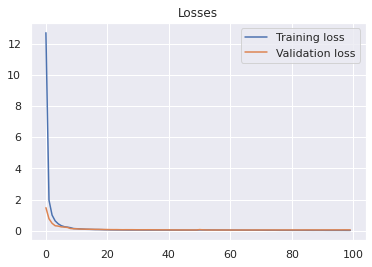

In [89]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


## Result Metrics after WF1+WF2 training



In [90]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf2 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf2)
print('Result metrics for CNN with MAE loss (WF1+WF2): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2):  {'mae': 0.15463217, 'rmse': 0.20582739, 'mse': 0.04236491}


In [91]:
#Plotting predictions
plot_predictions(df_result_cnn_wf2[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2) - 48h window')

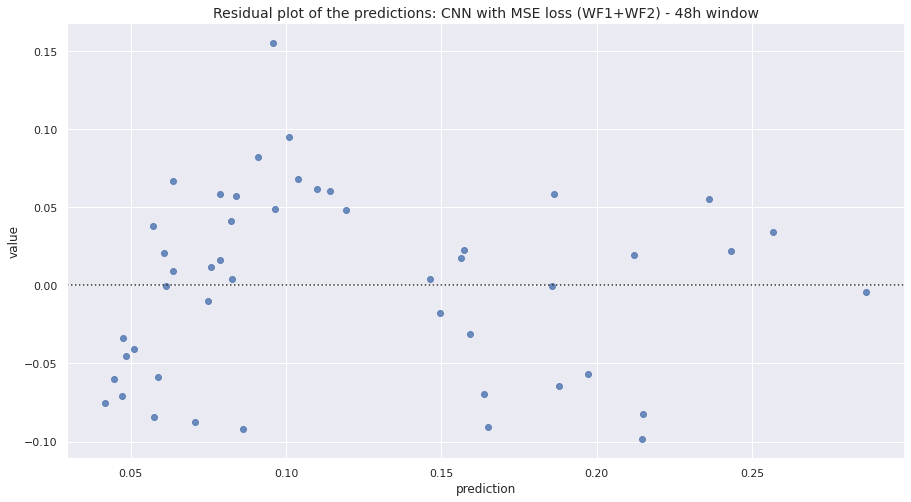

In [92]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf2[-96:-48]['prediction'], y=df_result_cnn_wf2[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0441	 Validation loss: 0.0503
[2/50] Training loss: 0.0401	 Validation loss: 0.0495
[3/50] Training loss: 0.0386	 Validation loss: 0.0491
[4/50] Training loss: 0.0369	 Validation loss: 0.0488
[5/50] Training loss: 0.0357	 Validation loss: 0.0485
[6/50] Training loss: 0.0346	 Validation loss: 0.0482
[7/50] Training loss: 0.0335	 Validation loss: 0.0479
[8/50] Training loss: 0.0328	 Validation loss: 0.0477
[9/50] Training loss: 0.0322	 Validation loss: 0.0475
[10/50] Training loss: 0.0313	 Validation loss: 0.0474
[20/50] Training loss: 0.0266	 Validation loss: 0.0463
[30/50] Training loss: 0.0236	 Validation loss: 0.0459
[40/50] Training loss: 0.0212	 Validation loss: 0.0457
[50/50] Training loss: 0.0193	 Validation loss: 0.0458


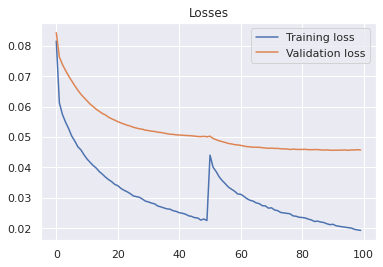

In [93]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [94]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf2 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf2)
print('Result metrics for LSTM with MAE loss (WF1+WF2): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2):  {'mae': 0.14213783, 'rmse': 0.19126414, 'mse': 0.03658197}


In [95]:
#Plotting predictions
plot_predictions(df_result_rnn_wf2[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2) - 48h window')

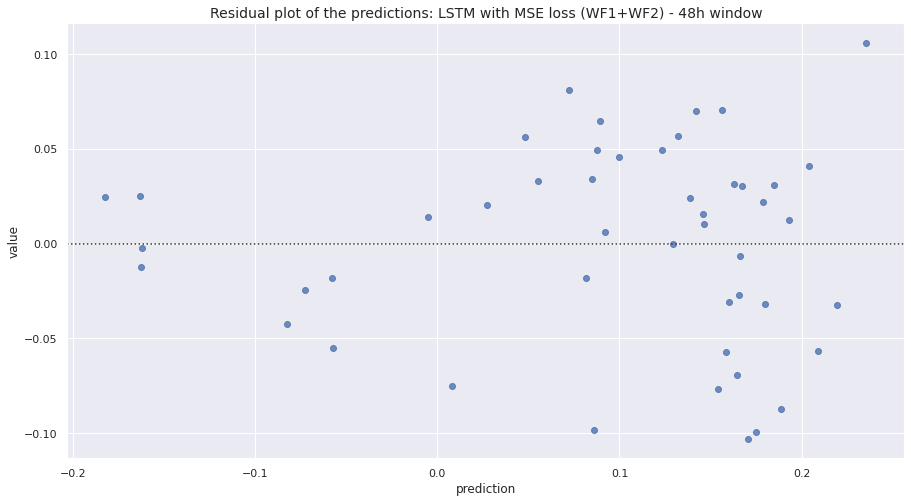

In [96]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf2[-96:-48]['prediction'], y=df_result_rnn_wf2[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2) - 48h window',size=14)

# + WF5
- since it has a similar seasonality

In [97]:
forecast_wf5_processed = pd.read_csv(path + 'wf5_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp5_unprocessed = train_wp5_unprocessed.tail(train_wp5_unprocessed.shape[0] -1)

forecast_wf5_processed.reset_index(drop=True, inplace=True)
train_wp5_unprocessed.reset_index(drop=True, inplace=True)
train_wf5_processed = pd.concat([forecast_wf5_processed, train_wp5_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf5 = generate_time_lags(train_wf5_processed, input_dim)

2009-7-5-05


In [98]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf5)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf5.columns, train_wf5)
  y_obs = train_wf5['wp5'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [99]:
# train baseline model
training_session = 'WF1+WF2+WF5'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5 {'mae': 0.13637780329213792, 'rmse': 0.1778876499034025, 'mse': 0.03164401598815549}


[1/50] Training loss: 0.0527	 Validation loss: 0.0622
[2/50] Training loss: 0.0421	 Validation loss: 0.0578
[3/50] Training loss: 0.0379	 Validation loss: 0.0554
[4/50] Training loss: 0.0363	 Validation loss: 0.0548
[5/50] Training loss: 0.0342	 Validation loss: 0.0538
[6/50] Training loss: 0.0322	 Validation loss: 0.0532
[7/50] Training loss: 0.0306	 Validation loss: 0.0531
[8/50] Training loss: 0.0300	 Validation loss: 0.0543
[9/50] Training loss: 0.0282	 Validation loss: 0.0538
[10/50] Training loss: 0.0279	 Validation loss: 0.0549
[20/50] Training loss: 0.0210	 Validation loss: 0.0631
[30/50] Training loss: 0.0181	 Validation loss: 0.0632
[40/50] Training loss: 0.0149	 Validation loss: 0.0651
[50/50] Training loss: 0.0148	 Validation loss: 0.0678


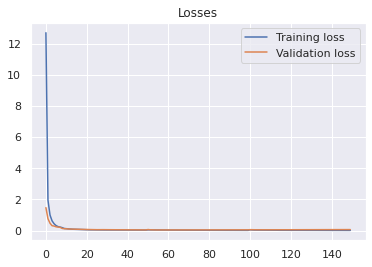

In [100]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Result Metrics after WF1+WF2+WF5 training

In [101]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf5 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf5)
print('Result metrics for CNN with MSE loss (WF1+WF2+WF5): ', result_metrics)

Result metrics for CNN with MSE loss (WF1+WF2+WF5):  {'mae': 0.16333306, 'rmse': 0.212089, 'mse': 0.044981748}


In [102]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf5[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1 + WF2 + WF5)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5) - 48h window')

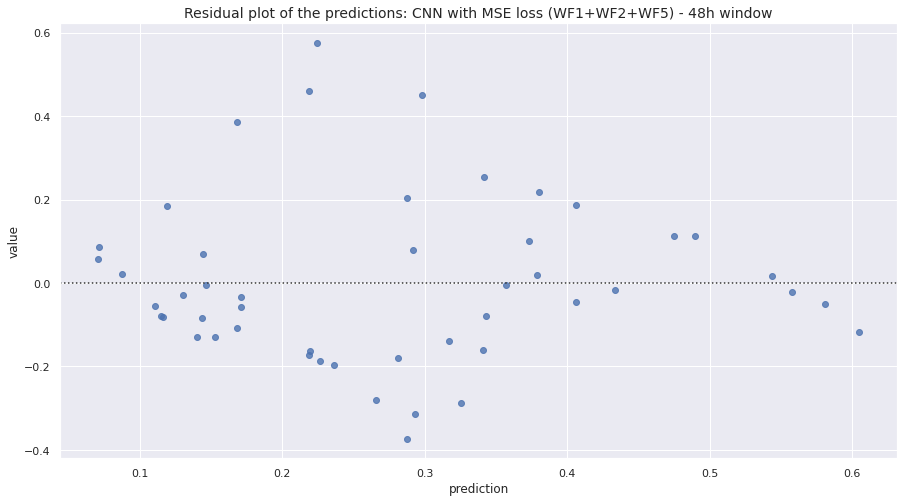

In [103]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf5[-96:-48]['prediction'], y=df_result_cnn_wf5[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0412	 Validation loss: 0.0657
[2/50] Training loss: 0.0379	 Validation loss: 0.0635
[3/50] Training loss: 0.0356	 Validation loss: 0.0625
[4/50] Training loss: 0.0346	 Validation loss: 0.0617
[5/50] Training loss: 0.0340	 Validation loss: 0.0609
[6/50] Training loss: 0.0329	 Validation loss: 0.0606
[7/50] Training loss: 0.0320	 Validation loss: 0.0601
[8/50] Training loss: 0.0315	 Validation loss: 0.0598
[9/50] Training loss: 0.0306	 Validation loss: 0.0594
[10/50] Training loss: 0.0301	 Validation loss: 0.0591
[20/50] Training loss: 0.0262	 Validation loss: 0.0569
[30/50] Training loss: 0.0235	 Validation loss: 0.0559
[40/50] Training loss: 0.0211	 Validation loss: 0.0554
[50/50] Training loss: 0.0192	 Validation loss: 0.0551


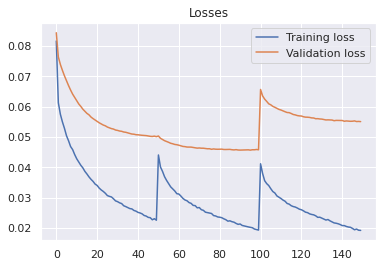

In [104]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [105]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf5 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf5)
print('Result metrics for LSTM with MSE loss (WF1+WF2+WF5): ', result_metrics)

Result metrics for LSTM with MSE loss (WF1+WF2+WF5):  {'mae': 0.14507817, 'rmse': 0.19262065, 'mse': 0.037102714}


In [106]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf5[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1 + WF2 + WF5)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5) - 48h window')

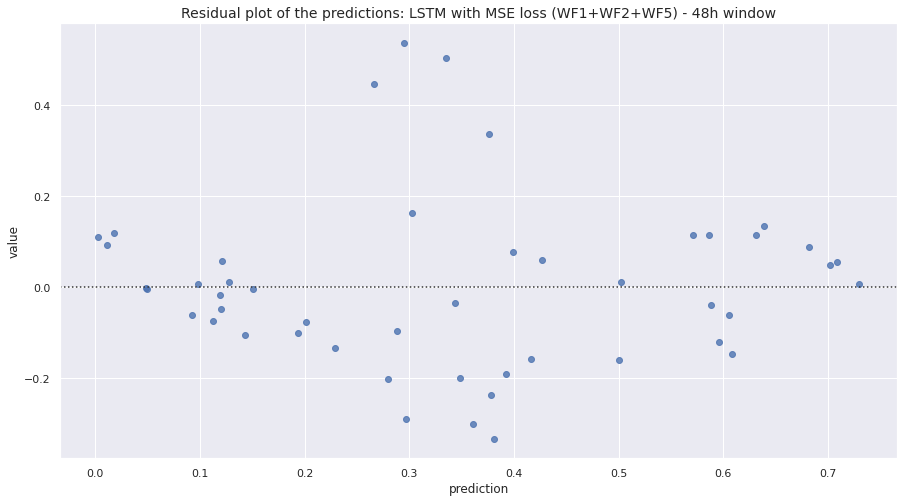

In [107]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf5[-96:-48]['prediction'], y=df_result_rnn_wf5[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5) - 48h window',size=14)

# + WF6

In [108]:
forecast_wf6_processed = pd.read_csv(path + 'wf6_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp6_unprocessed = train_wp6_unprocessed.tail(train_wp6_unprocessed.shape[0] -1)

forecast_wf6_processed.reset_index(drop=True, inplace=True)
train_wp6_unprocessed.reset_index(drop=True, inplace=True)
train_wf6_processed = pd.concat([forecast_wf6_processed, train_wp6_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf6 = generate_time_lags(train_wf6_processed, input_dim)

2009-7-5-05


In [109]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf6)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf6.columns, train_wf6)
  y_obs = train_wf6['wp6'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [110]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6 {'mae': 0.12222221031261887, 'rmse': 0.1617914614553125, 'mse': 0.026176476999845877}


[1/50] Training loss: 0.0454	 Validation loss: 0.0566
[2/50] Training loss: 0.0380	 Validation loss: 0.0563
[3/50] Training loss: 0.0287	 Validation loss: 0.0557
[4/50] Training loss: 0.0256	 Validation loss: 0.0563
[5/50] Training loss: 0.0245	 Validation loss: 0.0570
[6/50] Training loss: 0.0231	 Validation loss: 0.0552
[7/50] Training loss: 0.0221	 Validation loss: 0.0564
[8/50] Training loss: 0.0210	 Validation loss: 0.0548
[9/50] Training loss: 0.0203	 Validation loss: 0.0515
[10/50] Training loss: 0.0196	 Validation loss: 0.0504
[20/50] Training loss: 0.0166	 Validation loss: 0.0528
[30/50] Training loss: 0.0140	 Validation loss: 0.0531
[40/50] Training loss: 0.0139	 Validation loss: 0.0541
[50/50] Training loss: 0.0119	 Validation loss: 0.0578


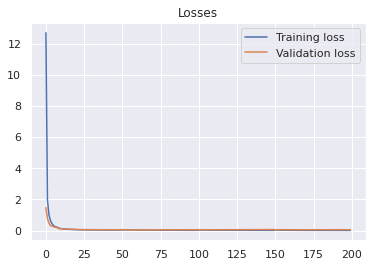

In [111]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


In [112]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf6 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf6)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6):  {'mae': 0.14405964, 'rmse': 0.19600405, 'mse': 0.038417585}


In [113]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf6[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1 + WF2 + WF5 + WF6)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6) - 48h window')

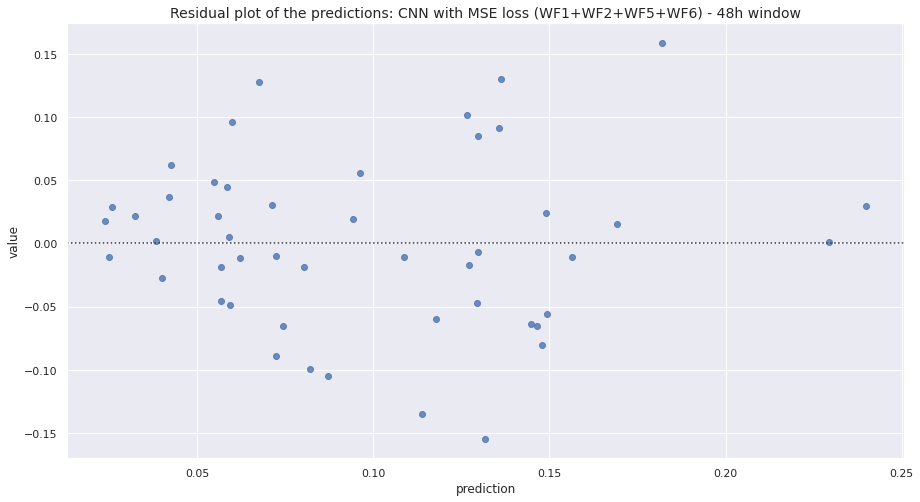

In [114]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf6[-96:-48]['prediction'], y=df_result_cnn_wf6[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0312	 Validation loss: 0.0503
[2/50] Training loss: 0.0280	 Validation loss: 0.0502
[3/50] Training loss: 0.0264	 Validation loss: 0.0499
[4/50] Training loss: 0.0253	 Validation loss: 0.0498
[5/50] Training loss: 0.0245	 Validation loss: 0.0497
[6/50] Training loss: 0.0237	 Validation loss: 0.0496
[7/50] Training loss: 0.0234	 Validation loss: 0.0495
[8/50] Training loss: 0.0228	 Validation loss: 0.0496
[9/50] Training loss: 0.0225	 Validation loss: 0.0498
[10/50] Training loss: 0.0219	 Validation loss: 0.0496
[20/50] Training loss: 0.0188	 Validation loss: 0.0492
[30/50] Training loss: 0.0169	 Validation loss: 0.0492
[40/50] Training loss: 0.0150	 Validation loss: 0.0496
[50/50] Training loss: 0.0135	 Validation loss: 0.0493


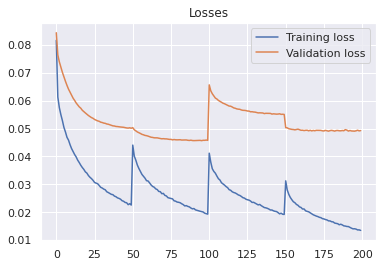

In [115]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [116]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf6 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf6)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6):  {'mae': 0.13191946, 'rmse': 0.17869438, 'mse': 0.031931683}


In [117]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf6[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1 + WF2 + WF5 + WF6)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6) - 48h window')

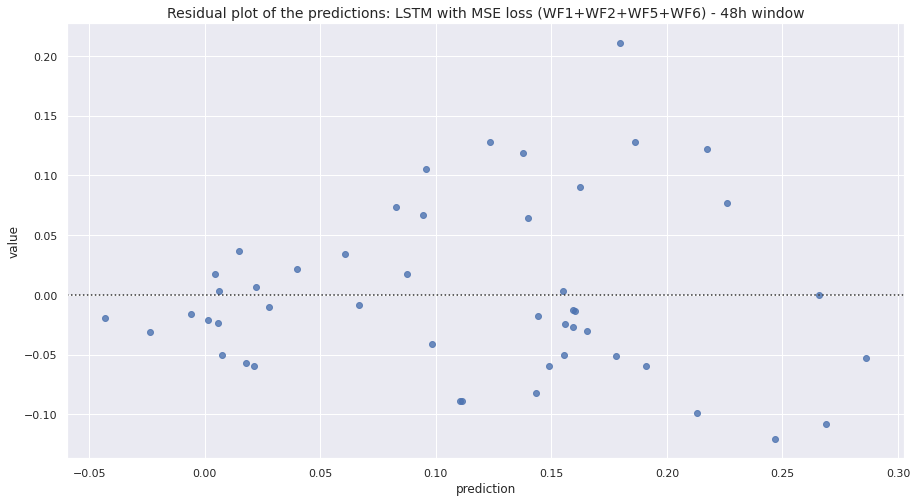

In [118]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf6[-96:-48]['prediction'], y=df_result_rnn_wf6[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6) - 48h window',size=14)

# + WF7

In [119]:
forecast_wf7_processed = pd.read_csv(path + 'wf7_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp7_unprocessed = train_wp7_unprocessed.tail(train_wp7_unprocessed.shape[0] -1)

forecast_wf7_processed.reset_index(drop=True, inplace=True)
train_wp7_unprocessed.reset_index(drop=True, inplace=True)
train_wf7_processed = pd.concat([forecast_wf7_processed, train_wp7_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf7 = generate_time_lags(train_wf7_processed, input_dim)

2009-7-5-05


In [120]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf7)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf7.columns, train_wf7)
  y_obs = train_wf7['wp7'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [121]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6+WF7 {'mae': 0.12573457994146098, 'rmse': 0.16156189340402768, 'mse': 0.026102245400294405}


[1/50] Training loss: 0.0285	 Validation loss: 0.0562
[2/50] Training loss: 0.0241	 Validation loss: 0.0545
[3/50] Training loss: 0.0197	 Validation loss: 0.0562
[4/50] Training loss: 0.0189	 Validation loss: 0.0539
[5/50] Training loss: 0.0180	 Validation loss: 0.0512
[6/50] Training loss: 0.0167	 Validation loss: 0.0528
[7/50] Training loss: 0.0168	 Validation loss: 0.0530
[8/50] Training loss: 0.0163	 Validation loss: 0.0513
[9/50] Training loss: 0.0169	 Validation loss: 0.0514
[10/50] Training loss: 0.0155	 Validation loss: 0.0542
[20/50] Training loss: 0.0137	 Validation loss: 0.0558
[30/50] Training loss: 0.0127	 Validation loss: 0.0548
[40/50] Training loss: 0.0133	 Validation loss: 0.0601
[50/50] Training loss: 0.0117	 Validation loss: 0.0618


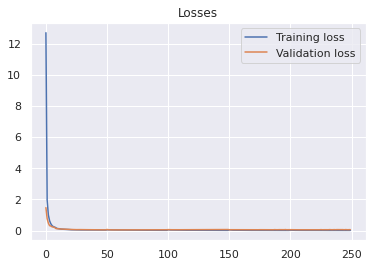

In [122]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


In [123]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf7 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf7)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7):  {'mae': 0.14516543, 'rmse': 0.19695574, 'mse': 0.038791563}


In [124]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf7[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2+WF5+WF6+WF7)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window')

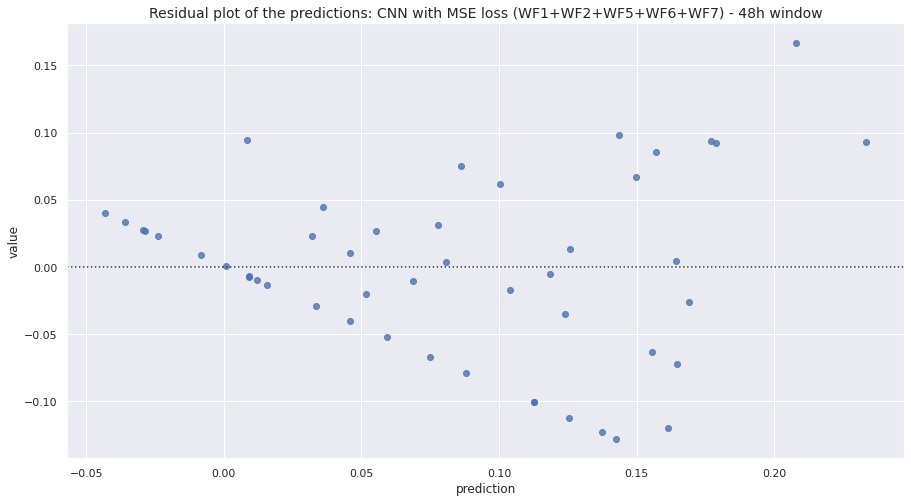

In [125]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf7[-96:-48]['prediction'], y=df_result_cnn_wf7[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0225	 Validation loss: 0.0485
[2/50] Training loss: 0.0206	 Validation loss: 0.0482
[3/50] Training loss: 0.0200	 Validation loss: 0.0480
[4/50] Training loss: 0.0192	 Validation loss: 0.0478
[5/50] Training loss: 0.0187	 Validation loss: 0.0478
[6/50] Training loss: 0.0181	 Validation loss: 0.0476
[7/50] Training loss: 0.0179	 Validation loss: 0.0476
[8/50] Training loss: 0.0177	 Validation loss: 0.0476
[9/50] Training loss: 0.0170	 Validation loss: 0.0475
[10/50] Training loss: 0.0167	 Validation loss: 0.0476
[20/50] Training loss: 0.0142	 Validation loss: 0.0474
[30/50] Training loss: 0.0127	 Validation loss: 0.0474
[40/50] Training loss: 0.0114	 Validation loss: 0.0478
[50/50] Training loss: 0.0102	 Validation loss: 0.0482


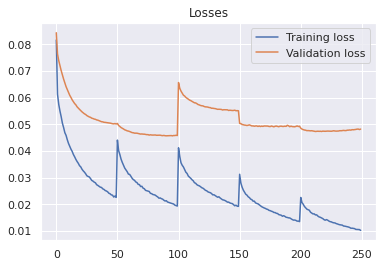

In [126]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [127]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf7 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf7)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7):  {'mae': 0.1329045, 'rmse': 0.1790145, 'mse': 0.03204619}


In [128]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf7[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window')

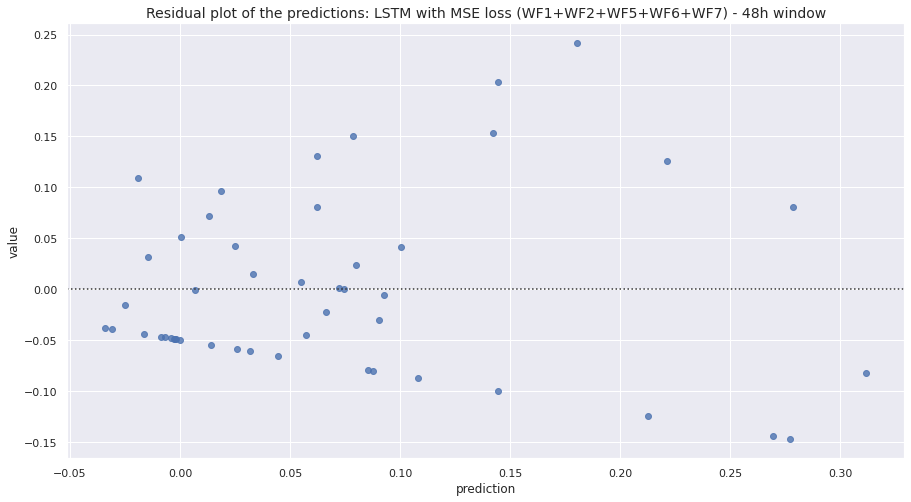

In [129]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf7[-96:-48]['prediction'], y=df_result_rnn_wf7[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window',size=14)

# + WF4

In [130]:
forecast_wf4_processed = pd.read_csv(path + 'wf4_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp4_unprocessed = train_wp4_unprocessed.tail(train_wp4_unprocessed.shape[0] -1)

forecast_wf4_processed.reset_index(drop=True, inplace=True)
train_wp4_unprocessed.reset_index(drop=True, inplace=True)
train_wf4_processed = pd.concat([forecast_wf4_processed, train_wp4_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf4 = generate_time_lags(train_wf4_processed, input_dim)

2009-7-5-05


In [131]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf4)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf4.columns, train_wf4)
  y_obs = train_wf4['wp4'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [132]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7+WF4'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6+WF7+WF4 {'mae': 0.12426398791332399, 'rmse': 0.1607254935043388, 'mse': 0.025832684262213253}


[1/50] Training loss: 0.0281	 Validation loss: 0.0542
[2/50] Training loss: 0.0250	 Validation loss: 0.0507
[3/50] Training loss: 0.0211	 Validation loss: 0.0554
[4/50] Training loss: 0.0193	 Validation loss: 0.0548
[5/50] Training loss: 0.0175	 Validation loss: 0.0553
[6/50] Training loss: 0.0172	 Validation loss: 0.0561
[7/50] Training loss: 0.0155	 Validation loss: 0.0544
[8/50] Training loss: 0.0158	 Validation loss: 0.0543
[9/50] Training loss: 0.0153	 Validation loss: 0.0563
[10/50] Training loss: 0.0145	 Validation loss: 0.0566
[20/50] Training loss: 0.0139	 Validation loss: 0.0573
[30/50] Training loss: 0.0112	 Validation loss: 0.0604
[40/50] Training loss: 0.0107	 Validation loss: 0.0600
[50/50] Training loss: 0.0107	 Validation loss: 0.0634


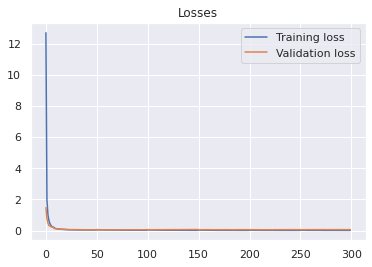

In [133]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [134]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf4 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf4)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4):  {'mae': 0.16146366, 'rmse': 0.2141522, 'mse': 0.045861166}


In [135]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf4[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window')

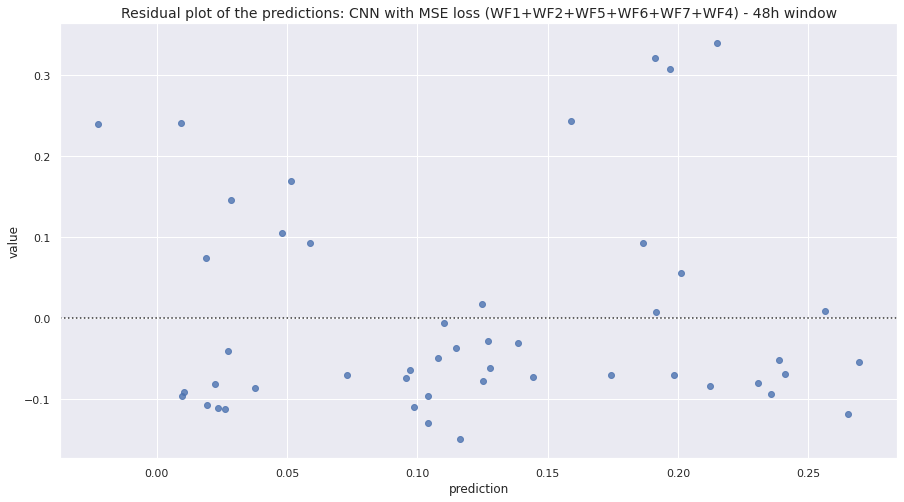

In [136]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf4[-96:-48]['prediction'], y=df_result_cnn_wf4[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0235	 Validation loss: 0.0454
[2/50] Training loss: 0.0211	 Validation loss: 0.0447
[3/50] Training loss: 0.0200	 Validation loss: 0.0443
[4/50] Training loss: 0.0193	 Validation loss: 0.0439
[5/50] Training loss: 0.0189	 Validation loss: 0.0438
[6/50] Training loss: 0.0182	 Validation loss: 0.0437
[7/50] Training loss: 0.0176	 Validation loss: 0.0435
[8/50] Training loss: 0.0173	 Validation loss: 0.0436
[9/50] Training loss: 0.0171	 Validation loss: 0.0435
[10/50] Training loss: 0.0166	 Validation loss: 0.0434
[20/50] Training loss: 0.0143	 Validation loss: 0.0432
[30/50] Training loss: 0.0126	 Validation loss: 0.0434
[40/50] Training loss: 0.0112	 Validation loss: 0.0436
[50/50] Training loss: 0.0100	 Validation loss: 0.0439


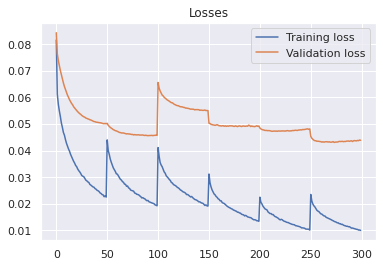

In [137]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [138]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf4 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf4)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4):  {'mae': 0.13159055, 'rmse': 0.17550057, 'mse': 0.030800449}


In [139]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf4[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window')

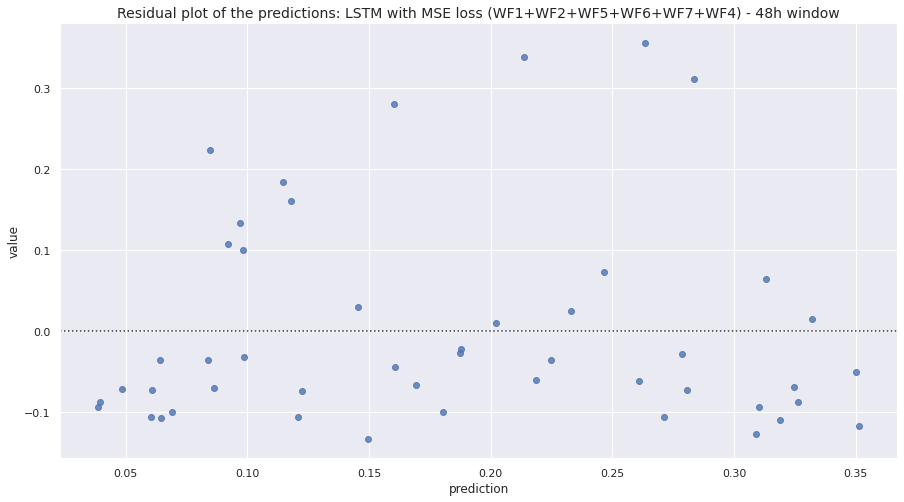

In [140]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf4[-96:-48]['prediction'], y=df_result_rnn_wf4[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window',size=14)

# + WF3

In [141]:
forecast_wf3_processed = pd.read_csv(path + 'wf3_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp3_unprocessed = train_wp3_unprocessed.tail(train_wp3_unprocessed.shape[0] -1)

forecast_wf3_processed.reset_index(drop=True, inplace=True)
train_wp3_unprocessed.reset_index(drop=True, inplace=True)
train_wf3_processed = pd.concat([forecast_wf3_processed, train_wp3_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf3 = generate_time_lags(train_wf3_processed, input_dim)

2009-7-5-05


In [142]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf3)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf3.columns, train_wf3)
  y_obs = train_wf3['wp3'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10035, 1)
Training features 10035


In [143]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7+WF4+WF3'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6+WF7+WF4+WF3 {'mae': 0.14044992727065594, 'rmse': 0.1811529863545633, 'mse': 0.0328164044651766}


[1/50] Training loss: 0.0429	 Validation loss: 0.0502
[2/50] Training loss: 0.0331	 Validation loss: 0.0546
[3/50] Training loss: 0.0313	 Validation loss: 0.0549
[4/50] Training loss: 0.0311	 Validation loss: 0.0544
[5/50] Training loss: 0.0290	 Validation loss: 0.0541
[6/50] Training loss: 0.0275	 Validation loss: 0.0552
[7/50] Training loss: 0.0292	 Validation loss: 0.0562
[8/50] Training loss: 0.0267	 Validation loss: 0.0546
[9/50] Training loss: 0.0258	 Validation loss: 0.0547
[10/50] Training loss: 0.0247	 Validation loss: 0.0551
[20/50] Training loss: 0.0210	 Validation loss: 0.0601
[30/50] Training loss: 0.0181	 Validation loss: 0.0614
[40/50] Training loss: 0.0163	 Validation loss: 0.0629
[50/50] Training loss: 0.0151	 Validation loss: 0.0652


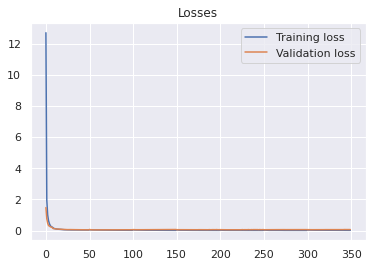

In [144]:
# CNN MAE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# Result Metrics after training with All Wind Farms (WFs)
 ### - Model: CNN with MSE loss


In [145]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf3 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf3)
print('Result metrics for CNN with MSE loss (): ', result_metrics)

Result metrics for CNN with MSE loss ():  {'mae': 0.1678971, 'rmse': 0.21425493, 'mse': 0.045905173}


In [146]:
#Plotting predictions
plot_predictions(df_result_cnn_wf3[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (all wind farms)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (all wind farms) - 48h window')

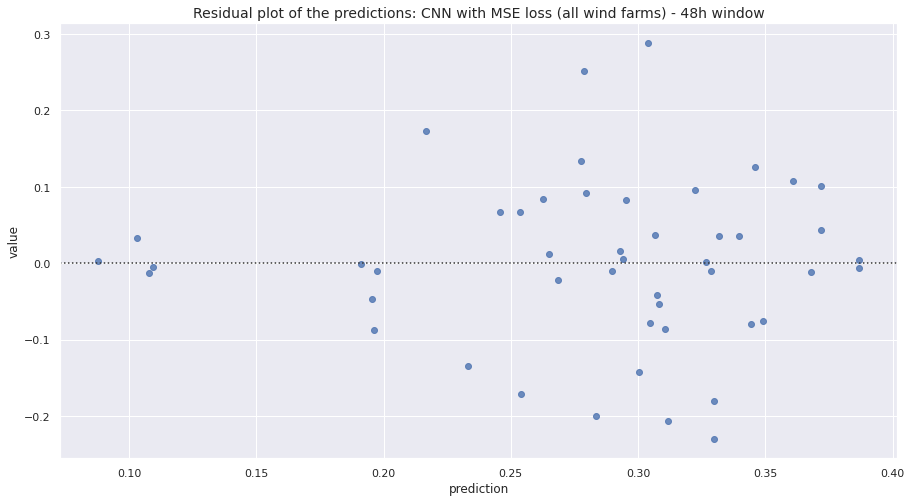

In [147]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf3[-96:-48]['prediction'], y=df_result_cnn_wf3[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (all wind farms) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0350	 Validation loss: 0.0545
[2/50] Training loss: 0.0314	 Validation loss: 0.0549
[3/50] Training loss: 0.0301	 Validation loss: 0.0549
[4/50] Training loss: 0.0288	 Validation loss: 0.0551
[5/50] Training loss: 0.0278	 Validation loss: 0.0548
[6/50] Training loss: 0.0270	 Validation loss: 0.0550
[7/50] Training loss: 0.0264	 Validation loss: 0.0549
[8/50] Training loss: 0.0258	 Validation loss: 0.0548
[9/50] Training loss: 0.0257	 Validation loss: 0.0548
[10/50] Training loss: 0.0249	 Validation loss: 0.0548
[20/50] Training loss: 0.0214	 Validation loss: 0.0543
[30/50] Training loss: 0.0193	 Validation loss: 0.0544
[40/50] Training loss: 0.0172	 Validation loss: 0.0546
[50/50] Training loss: 0.0153	 Validation loss: 0.0550


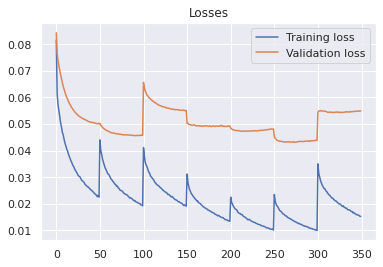

In [148]:
# LSTM MAE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [149]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf3 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf3)
print('Result metrics for LSTM with MSE loss (all wind farms): ', result_metrics)

Result metrics for LSTM with MSE loss (all wind farms):  {'mae': 0.14352793, 'rmse': 0.19260232, 'mse': 0.037095655}


In [150]:
#Plotting predictions
plot_predictions(df_result_rnn_wf3[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (all wind farms)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (all wind farms) - 48h window')

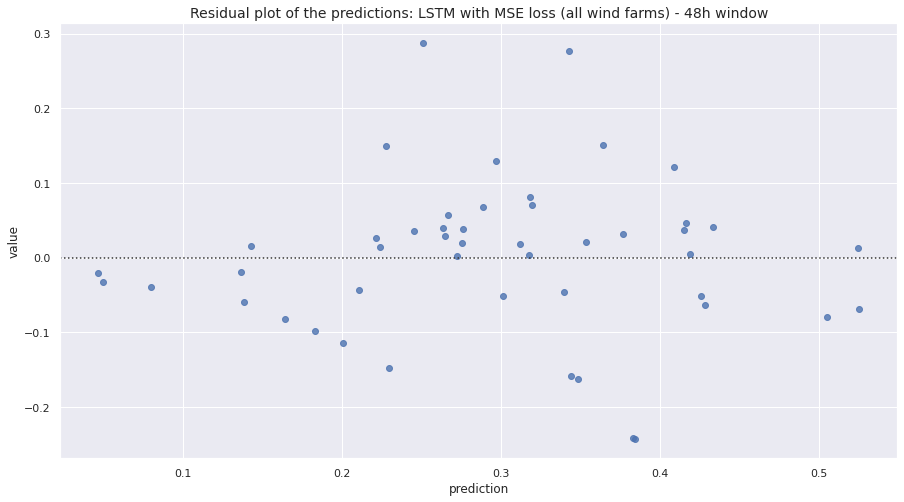

In [151]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf3[-96:-48]['prediction'], y=df_result_rnn_wf3[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (all wind farms) - 48h window',size=14)